In [1]:
# Importing necessary libraries for handling the data
import pandas as pd

# Loading the datasets provided
suicidewatch_posts = pd.read_csv('SuicideWatch_posts.csv')
depression_posts = pd.read_csv('depression_posts.csv')
depression_comments = pd.read_csv('depression_comments.csv')
suicidewatch_comments = pd.read_csv('SuicideWatch_comments.csv')


# Combining all posts datasets into a single DataFrame 'df_posts'
df_posts = pd.concat([suicidewatch_posts,depression_posts], ignore_index=True)

df_posts = df_posts.drop(columns=['Flair'])


# Combining all comments datasets into a single DataFrame 'df_comments'
df_comments = pd.concat([suicidewatch_comments,depression_comments], ignore_index=True)

# Displaying the structure of the combined datasets to confirm the merge
df_posts_shape = df_posts.shape
df_comments_shape = df_comments.shape

df_posts_head = df_posts.head()
df_comments_head = df_comments.head()

df_posts_shape, df_comments_shape, df_posts_head, df_comments_head


((10000, 8),
 (23042, 7),
                    User                                         Post Title  \
 0         gktqkbcnbr_jj           I just don’t care and want to end things   
 1        Sad_Cancel_705         I’ve decided to kill myself in 30 minutes    
 2           Thatmaa4986                      Suicidal at 34 weeks pregnant   
 3  Expensive_Flounder28  I finally figured out which way I'm going to k...   
 4  MalsAdaptiveDreaming  Thinking of jumping off a bridge above water. ...   
 
                                              Content  Score  Comments Count  \
 0                                                NaN      1               0   
 1  I 19m just wants someone to talk to before I d...      2               0   
 2  (28F) I am 34 weeks pregnant and struglling wi...      4               1   
 3  I'm going to wait until a very cold winter nig...      2               0   
 4  I wonder what the lethality is for 20-25 feet ...      1               0   
 
    Upvote Ratio

In [2]:
# Import required libraries
import re

from nltk.corpus import stopwords
import nltk
import spacy
# Download stopwords if not already available
#nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Define a comprehensive data cleaning function
def preprocess_text(text, remove_stopwords=True, convert_emojis=False):
    # Convert non-string entries to an empty string
    if not isinstance(text, str):
        text = ""
    # Remove URLs, emails, newline symbols, and HTML tags
    text = re.sub(r'http\S+|www.\S+|\b\w+@\w+\.\w+\b|<.*?>', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Optionally handle emojis
    if convert_emojis:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '[EMOJI]', text)  # Converts emojis to [EMOJI] label
    else:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)  # Removes emojis
    # Convert to lowercase
    text = text.lower()
    # Process text with SpaCy and optionally remove stopwords
    doc = nlp(text)
    if remove_stopwords:
        return ' '.join([token.lemma_ for token in doc if token.text not in stop_words])
    else:
        return ' '.join([token.lemma_ for token in doc])

# Apply this cleaning function to text columns in your datasets
df_posts['Content'] = df_posts['Content'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))
df_comments['Comment Body'] = df_comments['Comment Body'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))


In [3]:
# Importing necessary libraries for tokenization
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy

# Downloading NLTK resources if not already available
#nltk.download('punkt')
#nltk.download('punkt_tab')
# Loading SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define a function to perform tokenization
def tokenize_text(text, level='word', method='spacy'):
    """
    Tokenizes text based on specified level and method.

    Parameters:
    - text (str): Input text to be tokenized.
    - level (str): 'word' for word-level tokenization or 'sentence' for sentence-level tokenization.
    - method (str): 'spacy' for SpaCy tokenization, 'nltk' for NLTK tokenization.

    Returns:
    - list: List of tokens at the specified level.
    """
    if not isinstance(text, str):
        return []  # Return empty list if text is not a valid string
    
    if method == 'spacy':
        doc = nlp(text)
        if level == 'word':
            tokens = [token.text for token in doc]
        elif level == 'sentence':
            tokens = [sent.text for sent in doc.sents]
    elif method == 'nltk':
        if level == 'word':
            tokens = word_tokenize(text)
        elif level == 'sentence':
            tokens = sent_tokenize(text)
    
    return tokens

# Applying tokenization on 'Content' in posts and 'Comment Body' in comments

# For posts - SpaCy word-level and sentence-level tokenization
df_posts['SpaCy_Word_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='word', method='spacy'))
df_posts['SpaCy_Sentence_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='sentence', method='spacy'))

# For comments - NLTK word-level and sentence-level tokenization
df_comments['NLTK_Word_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='word', method='nltk'))
df_comments['NLTK_Sentence_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='sentence', method='nltk'))


In [4]:
# Import necessary libraries
import re
import spacy
from nltk.stem import PorterStemmer
from textblob import TextBlob
import contractions  # Import contractions module

# Load SpaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Initialize Porter Stemmer for stemming if needed
stemmer = PorterStemmer()

# Define preprocessing function
def preprocess_text(text, lemmatize=True, use_stemming=False, correct_spelling=False, expand_contractions=True):
    """
    Cleans and preprocesses text by lemmatizing or stemming, with optional spell correction and contraction expansion.
    
    Parameters:
    - text (str): The text to be processed.
    - lemmatize (bool): Whether to apply lemmatization (default is True).
    - use_stemming (bool): Whether to apply stemming (default is False).
    - correct_spelling (bool): Whether to perform spell correction (default is False).
    - expand_contractions (bool): Whether to expand contractions (default is True).
    
    Returns:
    - str: The processed text.
    """
    # Expand contractions if specified
    if expand_contractions:
        text = contractions.fix(text)

    # Convert text to lowercase
    text = text.lower()

    # Spell correction (optional)
    if correct_spelling:
        text = str(TextBlob(text).correct())

    # Tokenize and apply lemmatization or stemming
    processed_tokens = []
    if lemmatize:
        # Lemmatization using SpaCy
        doc = nlp(text)
        processed_tokens = [token.lemma_ for token in doc]
    elif use_stemming:
        # Stemming using NLTK
        words = text.split()
        processed_tokens = [stemmer.stem(word) for word in words]
    else:
        # If neither lemmatization nor stemming, just split the text
        processed_tokens = text.split()

    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Example usage: Concatenate title and body, apply preprocessing
df_posts['Processed_Text'] = df_posts.apply(
    lambda row: preprocess_text(f"{row['Post Title']} {row['Content']}", 
                                lemmatize=True, 
                                correct_spelling=False, 
                                expand_contractions=True),
    axis=1
)

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_1749/363357712.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm', order=['Low', 'Moderate', 'High'])


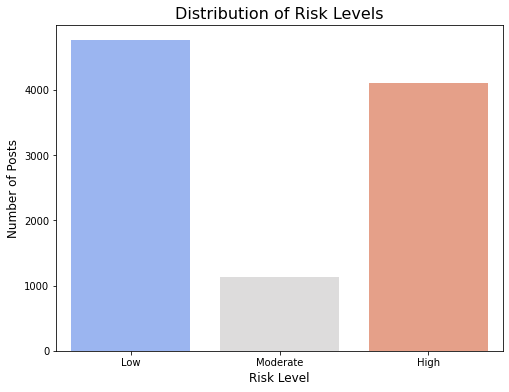

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define a function to classify Risk_Level
def classify_risk_level(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score <= -0.85:  # Strongly negative
        return 'High'
    elif -0.6 < sentiment_score <= -0.2:  # Moderately negative
        return 'Moderate'
    else:  # Neutral or positive
        return 'Low'

# Apply to the dataset
df_posts['Risk_Level'] = df_posts['Processed_Text'].apply(classify_risk_level)

# Visualize the distribution of Risk_Level
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm', order=['Low', 'Moderate', 'High'])
plt.title('Distribution of Risk Levels', fontsize=16)
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.show()


<h2>SHAP</h2>

In [7]:
import xgboost
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Splitting the dataset into training and testing sets
X = df_posts['Processed_Text']
y = df_posts['Risk_Level']

# Encode the string labels into numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert text data to numerical format using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert sparse matrices to dense arrays
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Train an XGBoost model
model = xgboost.XGBClassifier()  # Use XGBRegressor if y is continuous
model.fit(X_train_dense, y_train)

# Get feature names from TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()

# Explain the model's predictions using SHAP with feature names
explainer = shap.Explainer(model, X_train_dense, feature_names=feature_names)
shap_values = explainer(X_test_dense)

 99%|===================| 5956/6000 [01:44<00:00]        

In [10]:
# Print the mapping of class indices to original class labels
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Class Index to Label Mapping:", class_mapping)

Class Index to Label Mapping: {0: 'High', 1: 'Low', 2: 'Moderate'}


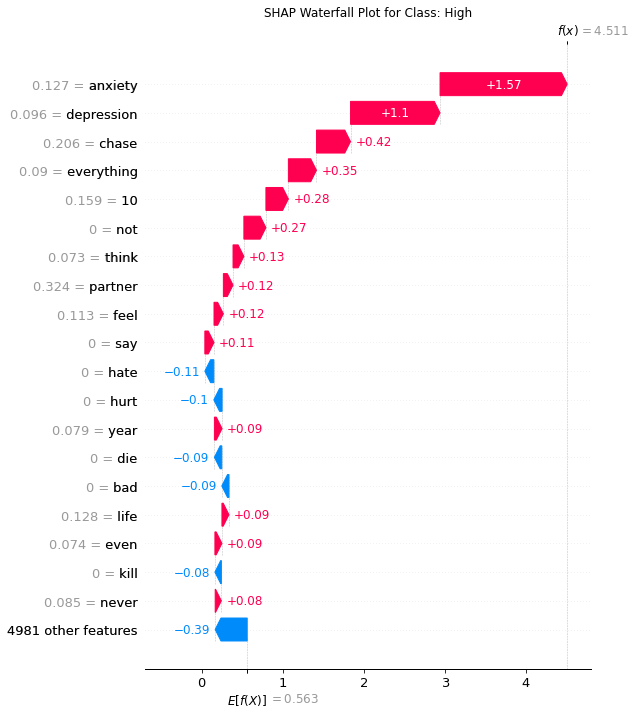

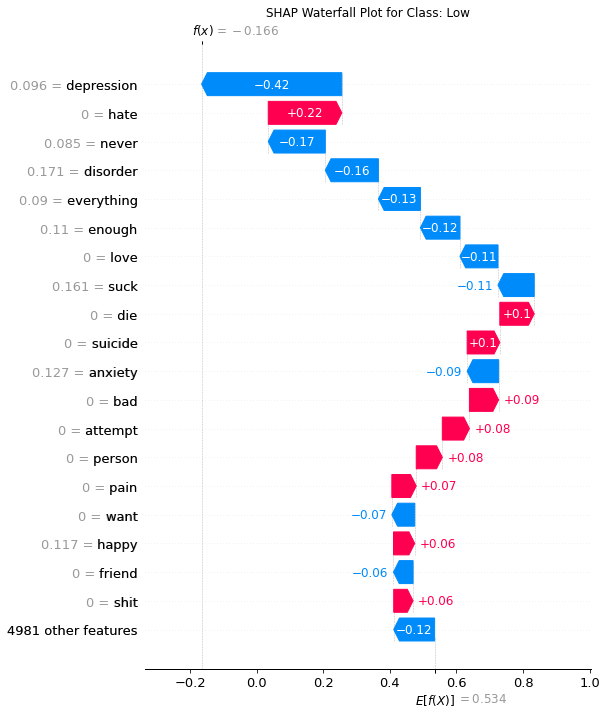

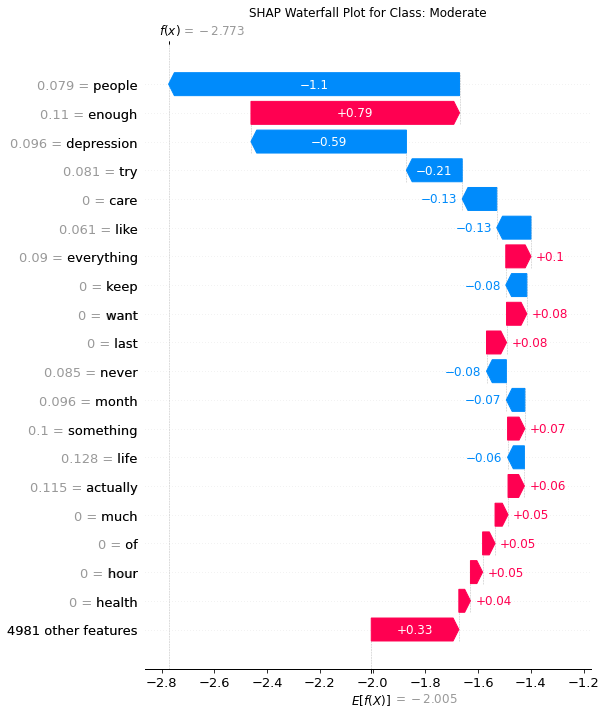

In [11]:
# Visualize the waterfall plot for the first instance and a specific class
# Loop through each class index

for class_index in range(3):
    shap_values_class = shap_values[..., class_index]  # Extract SHAP values for the specific class

    # Create a plot and add a title for the corresponding class label
    plt.title(f"SHAP Waterfall Plot for Class: {class_mapping[class_index]}")
    shap.plots.waterfall(shap_values_class[0], max_display=20)
    plt.show()  # Show the plot

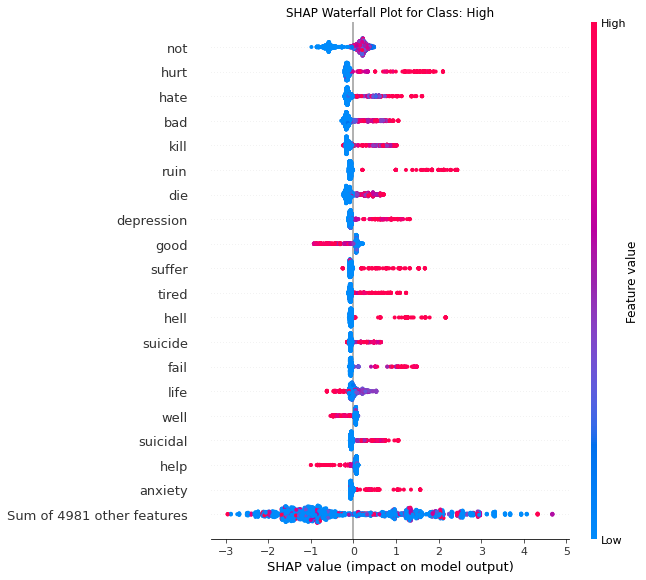

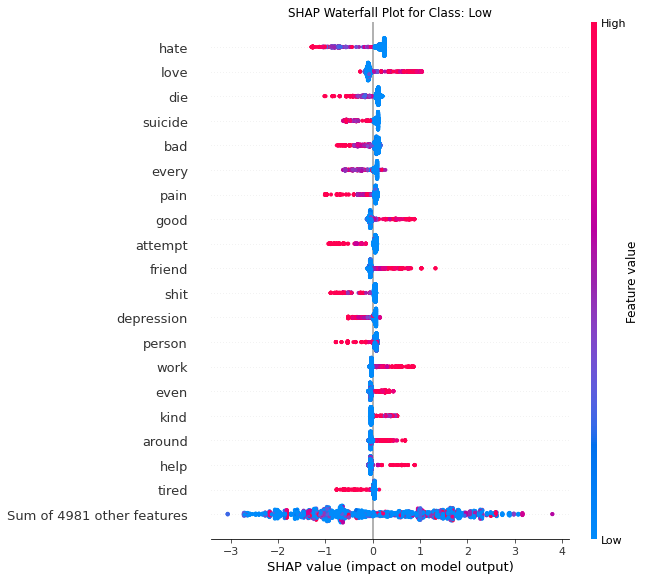

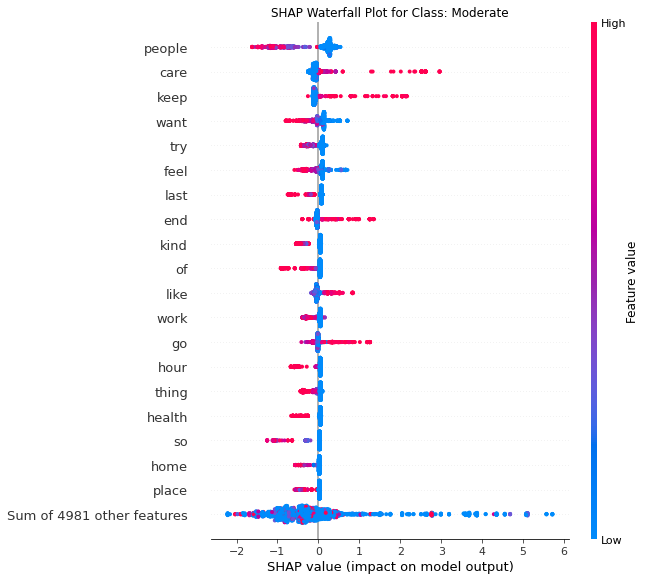

In [13]:
# Visualize the waterfall plot for the first instance and a specific class
# Loop through each class index

for class_index in range(3):
    shap_values_class = shap_values[..., class_index]  # Extract SHAP values for the specific class

    # Create a plot and add a title for the corresponding class label
    plt.title(f"SHAP Waterfall Plot for Class: {class_mapping[class_index]}")
    shap.plots.beeswarm(shap_values_class, max_display=20)
    plt.show()  # Show the plot